In [ ]:
import os
import cv2
import math
import joblib
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Conv2D, ZeroPadding2D, MaxPool2D, AveragePooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Activation, Dropout, BatchNormalization, concatenate
from tensorflow.keras.initializers import he_normal
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model

2024-03-26 09:28:10.085116: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-26 09:28:10.085208: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-26 09:28:10.261785: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
# Function to load data
def load_data(data_dir, target_names):
    img_arr = []
    img_label = []
    label_to_text = {}
    label = 0

    for dir_ in os.listdir(data_dir):
        if dir_ in target_names:
            for f in os.listdir(os.path.join(data_dir, dir_)):
                img = cv2.imread(os.path.join(data_dir, dir_, f), 0)
                img = cv2.resize(img, (64, 64))  # Resize image to 64x64
                img_arr.append(np.expand_dims(img, axis=2))
                img_label.append(label)
            print(f"loaded {dir_} images to numpy arrays...")
            label_to_text[label] = dir_
            label += 1

    img_arr = np.array(img_arr)
    img_label = np.array(img_label)
    img_label = OneHotEncoder(sparse=False).fit_transform(img_label.reshape(-1, 1))

    return img_arr, img_label, label_to_text

In [ ]:
target_names = ['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise']

# Load training data
data_dir_train = "/kaggle/input/fyp-dataset/RAFDB/RAFDB/train/"
img_arr_train, img_label_train, label_to_text_train = load_data(data_dir_train, target_names)

# Load test data
data_dir_test = "/kaggle/input/fyp-dataset/RAFDB/RAFDB/test/"
img_arr_test, img_label_test, label_to_text_test = load_data(data_dir_test, target_names)

INPUT_SHAPE = (64,64,1)
NUM_CLASSES = len(target_names)

loaded surprise images to numpy arrays...
loaded fear images to numpy arrays...
loaded angry images to numpy arrays...
loaded neutral images to numpy arrays...
loaded sad images to numpy arrays...
loaded disgust images to numpy arrays...
loaded happy images to numpy arrays...


/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


loaded surprise images to numpy arrays...
loaded fear images to numpy arrays...
loaded angry images to numpy arrays...
loaded neutral images to numpy arrays...
loaded sad images to numpy arrays...
loaded disgust images to numpy arrays...
loaded happy images to numpy arrays...


/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
total_images_train = 0
for dir_ in os.listdir(data_dir_train):
    if dir_ in target_names:
        count = 0
        for f in os.listdir(data_dir_train + dir_ + "/"):
            count += 1
        print(f"{dir_} has {count} number of training images")
        total_images_train += count

print(f"\ntotal training images are {total_images_train}\n")

surprise has 1290 number of training images
fear has 281 number of training images
angry has 705 number of training images
neutral has 2524 number of training images
sad has 1982 number of training images
disgust has 717 number of training images
happy has 4772 number of training images

total training images are 12271



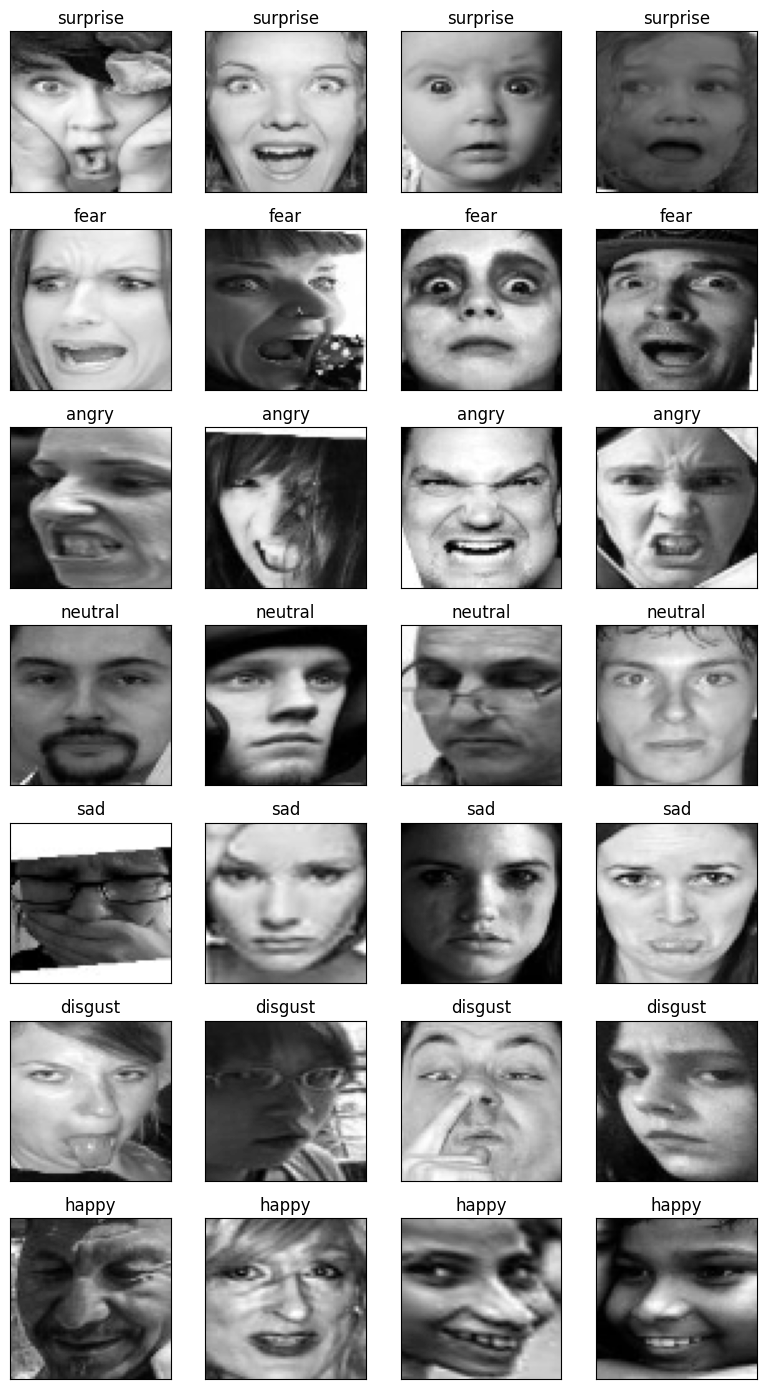

In [ ]:
num_emotions = len(target_names)
num_cols = 4
fig, axes = plt.subplots(num_emotions, num_cols, figsize=(num_cols*2, num_emotions*2))

idx = 0
for k in label_to_text_train:
    sample_indices = np.random.choice(np.where(img_label_train[:, k] == 1)[0], size=num_cols, replace=False)
    sample_images = img_arr_train[sample_indices]

    for i, img in enumerate(sample_images):
        ax = axes[idx, i]
        ax.imshow(img.reshape(64, 64), cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(label_to_text_train[k])

    idx += 1

plt.tight_layout()
plt.show()

In [ ]:
def inception_block(X,
                    filters_1x1: int,
                    filters_3x3_reduce: int,
                    filters_3x3: int,
                    filters_5x5_reduce: int,
                    filters_5x5: int,
                    filters_pool_proj: int,
                    block_name: str):

    conv_1x1 = Conv2D(
            filters=filters_1x1,
            kernel_size=(1, 1),
            padding='same',
            activation='relu',
            kernel_initializer=he_normal(seed=42),
            name=f"incepblock{block_name}_conv_1x1",
        )(X)

    conv_3x3_reduce = Conv2D(
            filters=filters_3x3_reduce,
            kernel_size=(1, 1),
            padding='same',
            activation='relu',
            kernel_initializer=he_normal(seed=42),
            name=f"incepblock{block_name}_conv_3x3_reduce",
        )(X)
    conv_3x3 = Conv2D(
            filters=filters_3x3,
            kernel_size=(3,3),
            padding='same',
            activation='relu',
            kernel_initializer=he_normal(seed=42),
            name=f"incepblock{block_name}_conv_3x3",
        )(conv_3x3_reduce)

    conv_5x5_reduce = Conv2D(
            filters=filters_5x5_reduce,
            kernel_size=(1, 1),
            padding='same',
            activation='relu',
            kernel_initializer=he_normal(seed=42),
            name=f"incepblock{block_name}_conv_5x5_reduce",
        )(X)
    conv_5x5 = Conv2D(
            filters=filters_5x5,
            kernel_size=(5,5),
            padding='same',
            activation='relu',
            kernel_initializer=he_normal(seed=42),
            name=f"incepblock{block_name}_conv_5x5",
        )(conv_5x5_reduce)

    pool_proj = MaxPool2D(
        pool_size=(3, 3),
        strides=(1, 1),
        padding='same',
        name=f"incepblock{block_name}_maxpool",
    )(X)
    conv_after_pool = Conv2D(
            filters=filters_pool_proj,
            kernel_size=(1, 1),
            padding='same',
            activation='relu',
            kernel_initializer=he_normal(seed=42),
            name=f"incepblock{block_name}_conv_afterpool",
        )(pool_proj)

    concated = concatenate([conv_1x1, conv_3x3, conv_5x5, conv_after_pool], axis=3, name=f"incepblock{block_name}_concat")
    return concated

In [ ]:
def auxiliary_block(X, out_shape: int, block_id: int):
    X = AveragePooling2D(
        pool_size=(3,3),
        strides=(1,1),
        padding='valid',
        name=f"auxblock{block_id}_avgpool",
    )(X)

    X = Conv2D(
            filters=128,
            kernel_size=(1,1),
            strides=(1,1),
            padding='same',
            activation='relu',
            name=f"auxblock{block_id}_conv2d",
    )(X)

    X = Flatten(name=f"auxblock{block_id}_flatten",)(X)

    X = Dense(units=128, activation='relu', name=f"auxblock{block_id}_dense1",)(X)

    X = Dropout(0.25, name=f"auxblock{block_id}_dropout",)(X)

    X = Dense(units=out_shape, activation='softmax', name=f"auxblock{block_id}_outlayer",)(X)
    return X

In [ ]:
def InceptionNet(in_shape, out_shape, show_summary=False):
    "shallow inception-net without auxiliary layers"

    model_in = Input(shape=in_shape, name="in_layer")

    X = Conv2D(
            filters=32,
            kernel_size=(3,3),
            padding='same',
            strides=(1,1),
            activation='relu',
            kernel_initializer=he_normal(seed=42)
        )(model_in)
    X = Conv2D(
            filters=64,
            kernel_size=(1,1),
            padding='same',
            strides=(1,1),
            activation='relu',
            kernel_initializer=he_normal(seed=42)
        )(X)

    X = MaxPool2D(
        (3, 3),
        padding='same',
        strides=(2, 2),
        )(X)

    X = inception_block(X,
            filters_1x1=64,
            filters_3x3_reduce=96,
            filters_3x3=128,
            filters_5x5_reduce=16,
            filters_5x5=32,
            filters_pool_proj=32,
            block_name='1a'
    )
    X = inception_block(X,
            filters_1x1=128,
            filters_3x3_reduce=128,
            filters_3x3=192,
            filters_5x5_reduce=32,
            filters_5x5=96,
            filters_pool_proj=64,
            block_name='1b'
    )

    X = MaxPool2D(
        (3, 3),
        padding='same',
        strides=(2, 2),
        )(X)

    X = inception_block(
        X,
        filters_1x1=192,
        filters_3x3_reduce=96,
        filters_3x3=208,
        filters_5x5_reduce=16,
        filters_5x5=48,
        filters_pool_proj=64,
        block_name='2a'
    )
    X = inception_block(
        X,
        filters_1x1=160,
        filters_3x3_reduce=112,
        filters_3x3=224,
        filters_5x5_reduce=24,
        filters_5x5=64,
        filters_pool_proj=64,
        block_name='2b'
    )

    X = MaxPool2D(
        (3, 3),
        padding='same',
        strides=(2, 2),
        )(X)

    X = inception_block(
        X,
        filters_1x1=256,
        filters_3x3_reduce=160,
        filters_3x3=320,
        filters_5x5_reduce=32,
        filters_5x5=128,
        filters_pool_proj=128,
        block_name='3a'
    )
    X = inception_block(
        X,
        filters_1x1=384,
        filters_3x3_reduce=192,
        filters_3x3=384,
        filters_5x5_reduce=48,
        filters_5x5=128,
        filters_pool_proj=128,
        block_name='3b'
    )

    X = GlobalAveragePooling2D()(X)

    X = Dense(128, activation='relu')(X)
    X = Dropout(0.25)(X)

    model_out = Dense(out_shape, activation="softmax", name="out_layer")(X)

    model = Model(model_in, model_out, name="InceptionNet")

    if show_summary:
        model.summary()

    return model

Model: "InceptionNet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ in_layer            │ (None, 64, 64, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 64, 64,    │        320 │ in_layer[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 64, 64,    │      2,112 │ conv2d[0][0]      │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 32, 32,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ incepblock1a_conv_… │ (None, 32, 32,    │      6,240 │ max_pooling2d[0]… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ incepblock1a_conv_… │ (None, 32, 32,    │      1,040 │ max_pooling2d[0]… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ incepblock1a_maxpo… │ (None, 32, 32,    │          0 │ max_pooling2d[0]… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ incepblock1a_conv_… │ (None, 32, 32,    │      4,160 │ max_pooling2d[0]… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ incepblock1a_conv_… │ (None, 32, 32,    │    110,720 │ incepblock1a_con… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ incepblock1a_conv_… │ (None, 32, 32,    │     12,832 │ incepblock1a_con… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ incepblock1a_conv_… │ (None, 32, 32,    │      2,080 │ incepblock1a_max… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ incepblock1a_concat │ (None, 32, 32,    │          0 │ incepblock1a_con… │
│ (Concatenate)       │ 256)              │            │ incepblock1a_con… │
│                     │                   │            │ incepblock1a_con… │
│                     │                   │            │ incepblock1a_con… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ incepblock1b_conv_… │ (None, 32, 32,    │     32,896 │ incepblock1a_con… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ incepblock1b_conv_… │ (None, 32, 32,    │      8,224 │ incepblock1a_con… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ incepblock1b_maxpo… │ (None, 32, 32,    │          0 │ incepblock1a_con… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ incepblock1b_conv_… │ (None, 32, 32,    │     32,896 │ incepblock1a_con… │
│ (Conv2D)            │ 128)              │            │                 

 Total params: 3,788,895 (14.45 MB)

 Trainable params: 3,788,895 (14.45 MB)

 Non-trainable params: 0 (0.00 B)

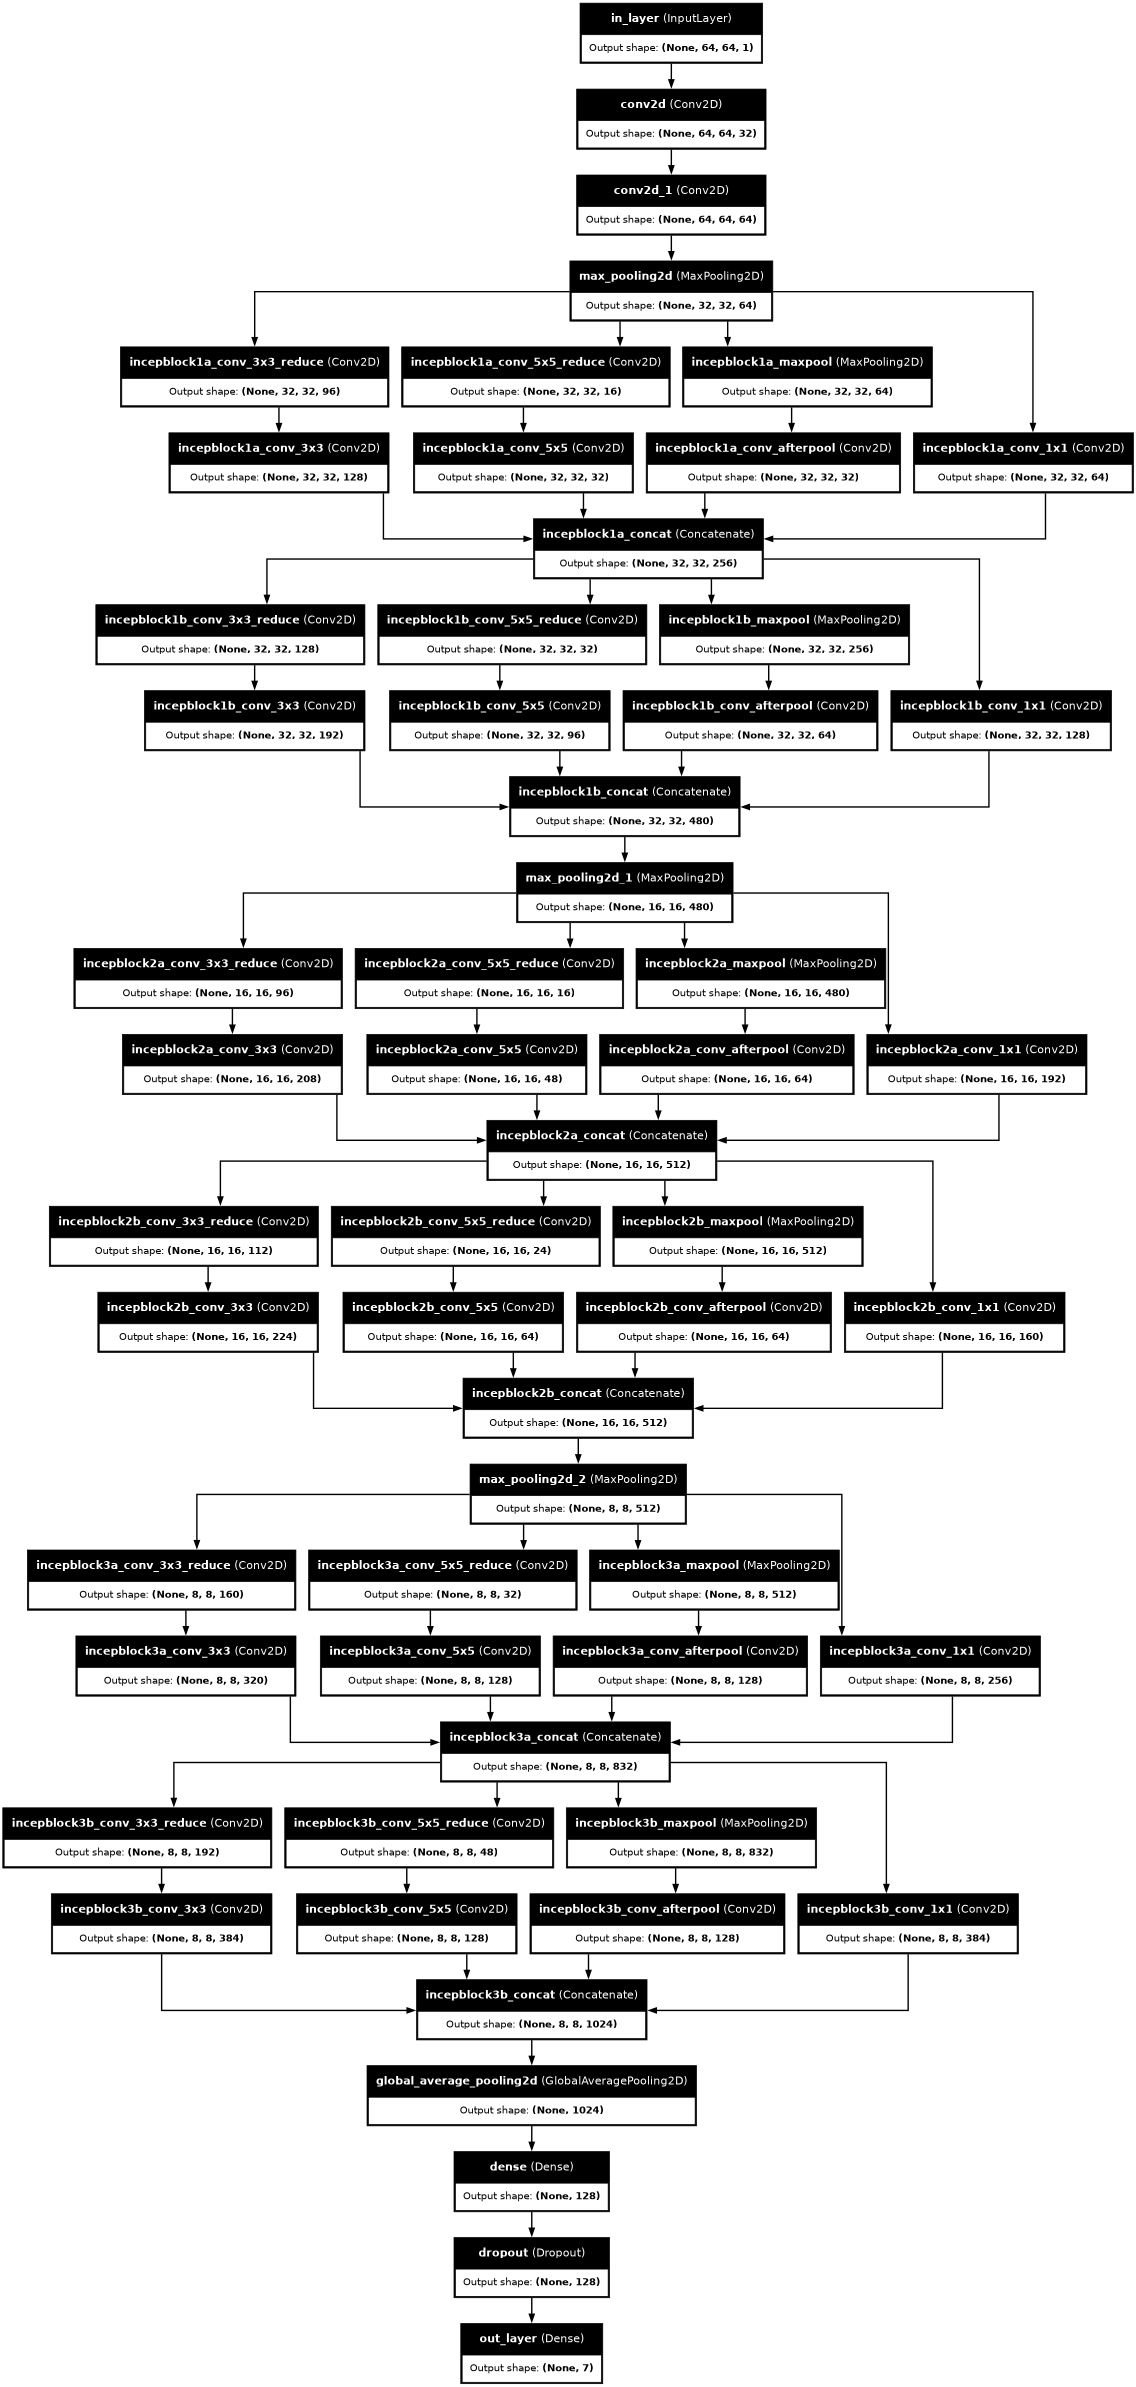

In [ ]:
model = InceptionNet(INPUT_SHAPE, NUM_CLASSES, show_summary=True)

plot_model(model, show_shapes=True, show_layer_names=True, expand_nested=True, dpi=50,)

In [ ]:
# Data Augmentation
train_datagen = ImageDataGenerator(
    rotation_range=8,
    width_shift_range=0.08,
    height_shift_range=0.08,
    shear_range=0.1,
    horizontal_flip=True,
    rescale=1./255  # Normalization
)

val_datagen = ImageDataGenerator(rescale=1./255)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_loss',
    min_delta=0.0001,
    factor=0.7,
    patience=3,
    min_lr=1e-6,
    verbose=1,
)

early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.0005,
    patience=20,
    verbose=1,
    restore_best_weights=True,
)

In [ ]:
batch_size = 32
loss = "categorical_crossentropy"
optim = optimizers.Adam(0.001)
epochs = 100

In [ ]:
# Applying data augmentation to the images

train_generator = train_datagen.flow_from_directory(
        data_dir_train,
        target_size=(64, 64),
        color_mode='grayscale',  # Convert images to grayscale
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True

)
val_generator = val_datagen.flow_from_directory(
        data_dir_test,
        target_size=(64, 64),
        color_mode='grayscale',
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
)

In [ ]:
model.compile(
        loss=loss,
        optimizer=optim,
        metrics=['accuracy'],
)

# train_datagen.fit(img_arr_train)

# Fit the data generator on validation data
# val_datagen.fit(img_arr_test)

# Training the model

history_InceptionNet = model.fit(x = train_generator,
                                 steps_per_epoch=int(len(img_arr_train) / batch_size),
                                 epochs = epochs,
                                 validation_data = val_generator,
                                 callbacks = [lr_scheduler, early_stopping],
)

Epoch 1/100


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


  2/383 ━━━━━━━━━━━━━━━━━━━━ 29s 78ms/step - accuracy: 0.1719 - loss: 3.1988   

I0000 00:00:1711445543.185597     110 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1711445543.239736     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


275/383 ━━━━━━━━━━━━━━━━━━━━ 18s 169ms/step - accuracy: 0.3726 - loss: 1.7843

W0000 00:00:1711445589.460631     109 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


383/383 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.3765 - loss: 1.7506

W0000 00:00:1711445598.127893     107 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


383/383 ━━━━━━━━━━━━━━━━━━━━ 104s 172ms/step - accuracy: 0.3765 - loss: 1.7504 - val_accuracy: 0.3882 - val_loss: 1.5756 - learning_rate: 0.0010
Epoch 2/100
  1/383 ━━━━━━━━━━━━━━━━━━━━ 17s 46ms/step - accuracy: 0.4062 - loss: 1.7504

W0000 00:00:1711445608.871917     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


383/383 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.4062 - loss: 1.7504 - val_accuracy: 0.3898 - val_loss: 1.6219 - learning_rate: 0.0010
Epoch 3/100
383/383 ━━━━━━━━━━━━━━━━━━━━ 25s 64ms/step - accuracy: 0.3959 - loss: 1.5971 - val_accuracy: 0.4094 - val_loss: 1.5090 - learning_rate: 0.0010
Epoch 4/100
383/383 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.4688 - loss: 1.4187 - val_accuracy: 0.4071 - val_loss: 1.5247 - learning_rate: 0.0010
Epoch 5/100
383/383 ━━━━━━━━━━━━━━━━━━━━ 25s 65ms/step - accuracy: 0.4086 - loss: 1.5635 - val_accuracy: 0.4658 - val_loss: 1.3994 - learning_rate: 0.0010
Epoch 6/100
383/383 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.4688 - loss: 1.4189 - val_accuracy: 0.4635 - val_loss: 1.4098 - learning_rate: 0.0010
Epoch 7/100
383/383 ━━━━━━━━━━━━━━━━━━━━ 26s 66ms/step - accuracy: 0.4539 - loss: 1.4561 - val_accuracy: 0.5235 - val_loss: 1.3031 - learning_rate: 0.0010
Epoch 8/100
383/383 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.5000 - loss: 1.3634 -

In [ ]:
history = pd.DataFrame(history_InceptionNet.history)
history

,accuracy,loss,val_accuracy,val_loss,learning_rate
0,0.386306,1.659696,0.388201,1.575626,0.001000
1,0.406250,1.750430,0.389830,1.621884,0.001000
2,0.395294,1.588894,0.409387,1.508952,0.001000
3,0.468750,1.418714,0.407106,1.524732,0.001000
4,0.422502,1.533803,0.465776,1.399419,0.001000
...,...,...,...,...,...
84,0.911349,0.246225,0.786832,0.753175,0.000005
85,0.968750,0.193125,0.786832,0.753090,0.000005
86,0.912493,0.242307,0.788462,0.752409,0.000005
87,0.937500,0.262875,0.788136,0.752453,0.000003


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

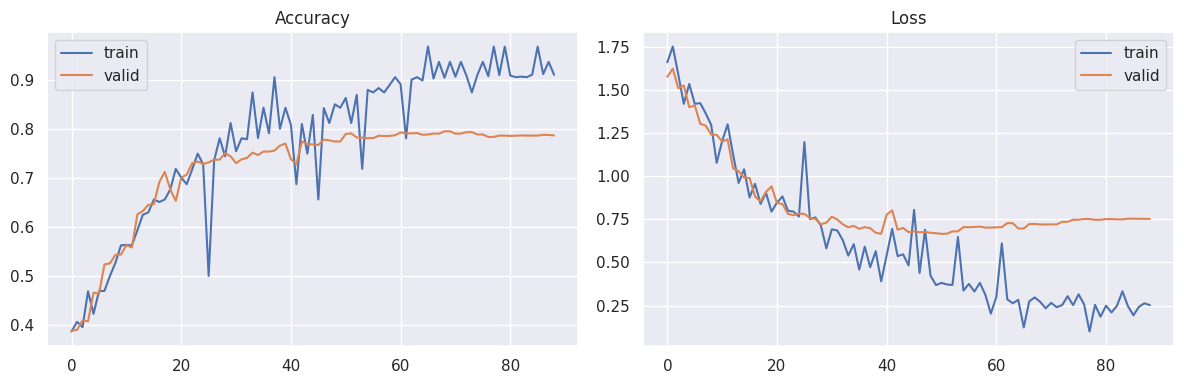

In [ ]:
sns.set()
fig = plt.figure(figsize=(12, 4))

ax = plt.subplot(1, 2, 1)
sns.lineplot(x=history_InceptionNet.epoch, y=history_InceptionNet.history['accuracy'], label='train')
sns.lineplot(x=history_InceptionNet.epoch, y=history_InceptionNet.history['val_accuracy'], label='valid')
plt.title('Accuracy')
plt.tight_layout()

ax = plt.subplot(1, 2, 2)
sns.lineplot(x=history_InceptionNet.epoch, y=history_InceptionNet.history['loss'], label='train')
sns.lineplot(x=history_InceptionNet.epoch, y=history_InceptionNet.history['val_loss'], label='valid')
plt.title('Loss')
plt.tight_layout()

plt.show()

384/384 - 21s - 54ms/step - accuracy: 0.9128 - loss: 0.2402


W0000 00:00:1711446853.551676     110 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



train Accuracy: 0.912802517414093
96/96 - 3s - 33ms/step - accuracy: 0.7956 - loss: 0.7197

Test Accuracy: 0.7956323623657227
 6/96 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step

W0000 00:00:1711446858.917424     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


96/96 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step


W0000 00:00:1711446863.854251     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Classification Report:
               precision    recall  f1-score   support

       angry       0.69      0.73      0.71       162
     disgust       0.50      0.40      0.44       160
        fear       0.57      0.49      0.53        74
       happy       0.92      0.88      0.90      1185
     neutral       0.73      0.80      0.77       680
         sad       0.73      0.76      0.74       478
    surprise       0.82      0.82      0.82       329

    accuracy                           0.80      3068
   macro avg       0.71      0.70      0.70      3068
weighted avg       0.80      0.80      0.80      3068



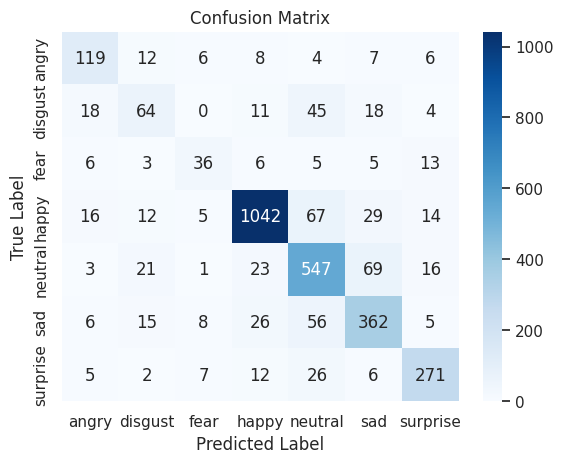

In [ ]:
train_loss, train_acc = model.evaluate(train_generator, verbose=2)
print(f"\ntrain Accuracy: {train_acc}")

test_loss, test_acc = model.evaluate(val_generator, verbose=2)
print(f"\nTest Accuracy: {test_acc}")

# Make predictions
predictions = model.predict(val_generator)
predicted_classes = np.argmax(predictions, axis=1)

# Get true classes
true_classes = val_generator.classes
class_labels = list(val_generator.class_indices.keys())

# Generate classification report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Classification Report:\n", report)

# Generate confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

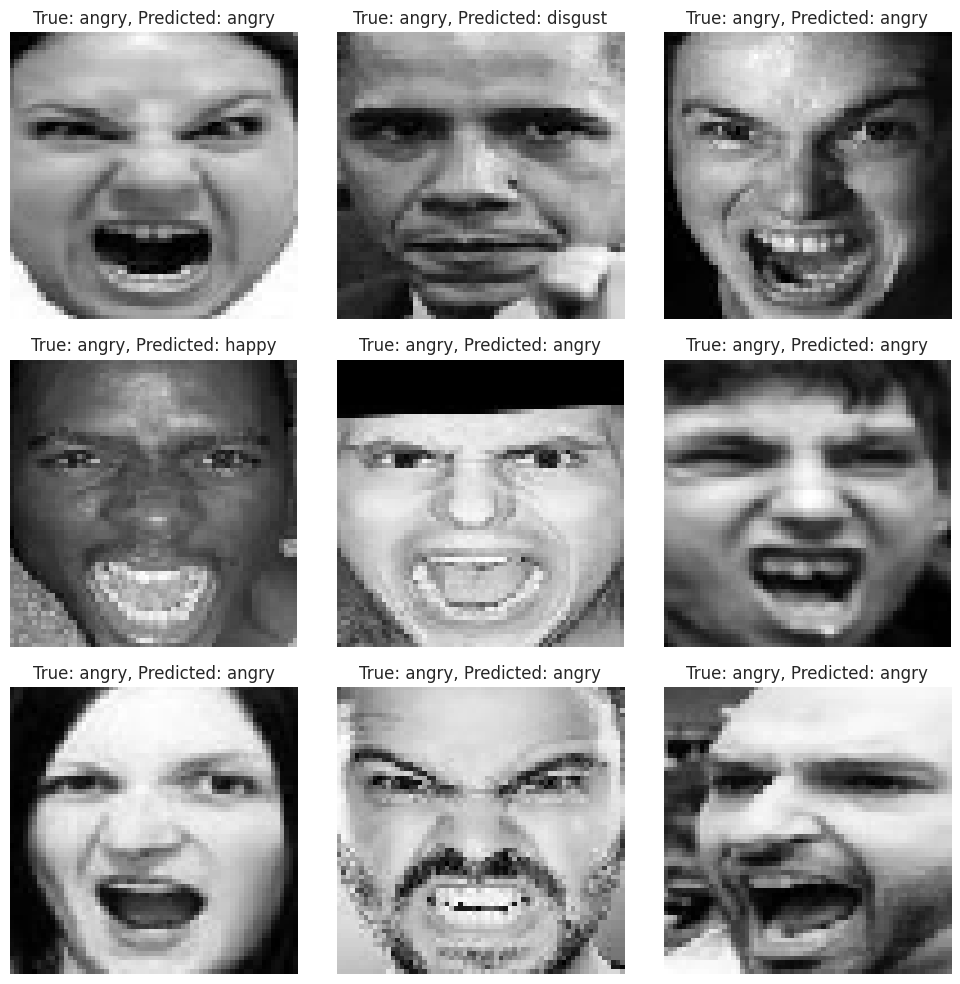

In [ ]:
import random

# Visualize random predictions
num_samples_to_show = 9
sample_images, sample_labels = next(val_generator)
random_indices = random.sample(range(len(sample_images)), num_samples_to_show)

plt.figure(figsize=(10, 10))
for i, idx in enumerate(random_indices):
    plt.subplot(3, 3, i + 1)
    plt.imshow(sample_images[idx].reshape(64, 64), cmap='gray')
    plt.title(f"True: {class_labels[np.argmax(sample_labels[idx])]}, Predicted: {class_labels[predicted_classes_sample[idx]]}")
    plt.axis('off')
plt.tight_layout()
plt.show()
